In [1]:
# --- NOTEBOOK 03: PREDICTIVE MODELING (Multi-Model) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics & Evaluation
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

# Konfigurasi Tampilan
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings("ignore")

In [8]:
# 1. LOAD DATA SIAP PAKAI
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

print(f"✅ Data Berhasil Dimuat: {len(df)} baris")
print("Kolom Tersedia:")
print(df.columns.tolist())
print(f"Rentang Data: {df['date'].min()} s.d {df['date'].max()}")

✅ Data Berhasil Dimuat: 1561206 baris
Kolom Tersedia:
['race_id', 'date', 'rank', 'horse_name', 'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', 'time_seconds', 'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', 'race_seq_since_break', 'jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate', 'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id', 'running_style_id', 'dist_cat_id']
Rentang Data: 1986-01-05 00:00:00 s.d 2021-07-31 00:00:00


In [3]:
# --- PERBAIKAN DATA LEAKAGE ---
print("Memperbaiki Data Leakage pada Running Style...")

df = df.sort_values(by=['horse_name', 'date'])
df['prev_running_style_id'] = df.groupby('horse_name')['running_style_id'].shift(1)
df['prev_running_style_id'] = df['prev_running_style_id'].fillna(-1).astype(int)

if 'running_style_id' in df.columns:
    df = df.drop(columns=['running_style_id'])

print("✅ Leakage diperbaiki!")

Memperbaiki Data Leakage pada Running Style...
✅ Leakage diperbaiki!


In [4]:
# --- TAHAP 1: DEFINISI FITUR & TARGET ---
from sklearn.impute import SimpleImputer # Import Imputer

# 1. Buat Target
# Target 1: Win (Juara 1)
df['target_win'] = (df['rank'] == 1).astype(int)
# Target 2: Top 3 (Juara 1, 2, 3)
df['target_top3'] = (df['rank'] <= 3).astype(int)

# 2. Tentukan Fitur
# Pastikan membuang kolom string/objek yang tidak bisa di-scale
drop_cols = ['race_id', 'date', 'rank', 'target_win', 'target_top3', 'horse_no', 'horse_name', 'time_seconds'] 
# Catatan: Tambahkan kolom lain yang bukan angka jika masih error
features = [c for c in df.columns if c not in drop_cols and df[c].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Jumlah Fitur: {len(features)}")

# --- TAHAP 2: SPLITTING DATA (TIME SERIES) ---
val_start_date = '2019-01-01' # Sesuaikan tanggal split Anda
test_start_date = '2020-01-01'

# Split Dataframes
train_df = df[df['date'] < val_start_date]
val_df = df[(df['date'] >= val_start_date) & (df['date'] < test_start_date)]
test_df = df[df['date'] >= test_start_date]

print(f"Data Train : {len(train_df)} baris")
print(f"Data Val   : {len(val_df)} baris")
print(f"Data Test  : {len(test_df)} baris")

# Siapkan X (Raw)
X_train = train_df[features].copy()
X_val = val_df[features].copy()
X_test = test_df[features].copy()

# --- STEP PENTING: IMPUTASI & SCALING UNTUK LOGISTIC/GNB ---
# 1. Imputasi (Isi NaN dengan rata-rata kolom)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=features)

# 2. Scaling (Standarisasi)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=features)

# Siapkan Target
targets = {
    'Win': {'train': train_df['target_win'], 'val': val_df['target_win'], 'test': test_df['target_win']},
    'Top3': {'train': train_df['target_top3'], 'val': val_df['target_top3'], 'test': test_df['target_top3']}
}

Jumlah Fitur: 23
Data Train : 1441935 baris
Data Val   : 45635 baris
Data Test  : 73636 baris


In [5]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, columns=['Pred 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.show()

def plot_pr_auc(y_true, y_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.3f}')
    plt.plot([0, 1], [y_true.mean(), y_true.mean()], linestyle='--', label='No Skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()
    return pr_auc

def run_model(model, model_name, X_tr, y_tr, X_v, y_v, X_te, y_te, is_tree=False):
    print(f"\n{'='*20} Training {model_name} {'='*20}")
    
    # Fit Model
    if is_tree and model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
        # Menggunakan early stopping untuk Tree-based models
        eval_set = [(X_tr, y_tr), (X_v, y_v)]
        model.fit(X_tr, y_tr, eval_set=eval_set, verbose=False)
    else:
        model.fit(X_tr, y_tr)
        
    # Predict (Gunakan Data Test untuk Evaluasi Akhir)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    # Metrics
    auc_score = roc_auc_score(y_te, y_prob)
    f1 = f1_score(y_te, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"ROC AUC   : {auc_score:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"Precision : {precision:.4f}")
    
    # Plots
    plot_confusion_matrix(y_te, y_pred, f'Confusion Matrix: {model_name}')
    pr_auc = plot_pr_auc(y_te, y_prob, f'PR Curve: {model_name}')
    
    return {
        'Model': model_name,
        'AUC': auc_score,
        'F1': f1,
        'Recall': recall,
        'Precision': precision,
        'PR_AUC': pr_auc
    }

Folder 'trained_models' berhasil dibuat.


################# TARGET: Win #################

==================== Training LogisticRegression (Win) ====================
ROC AUC   : 0.8229
F1 Score  : 0.2753
Recall    : 0.8109
Precision : 0.1658


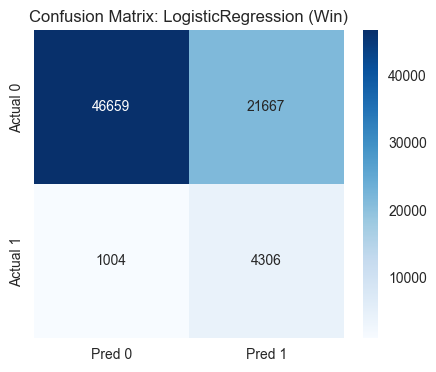

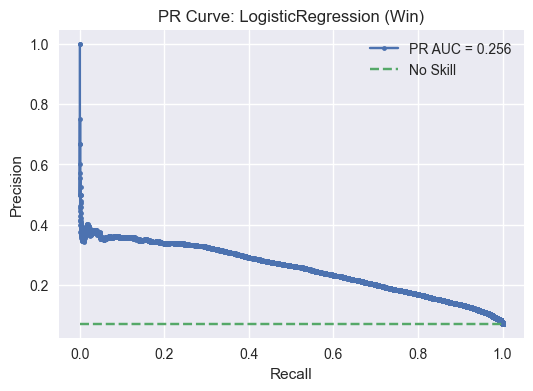

💾 Model tersimpan: trained_models/model_LogisticRegression_Win.pkl

==================== Training GaussianNB (Win) ====================
ROC AUC   : 0.7812
F1 Score  : 0.2761
Recall    : 0.5772
Precision : 0.1814


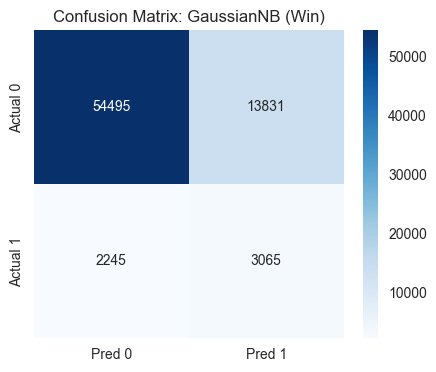

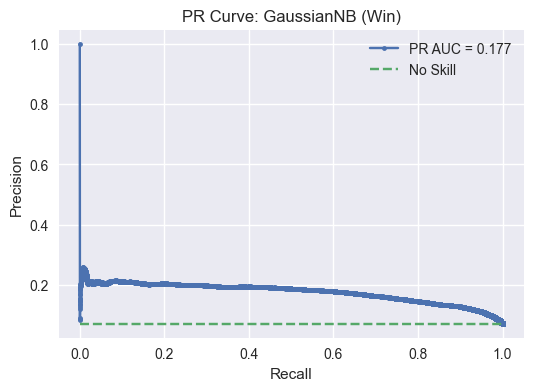

💾 Model tersimpan: trained_models/model_GaussianNB_Win.pkl

==================== Training XGBoost (Win) ====================
ROC AUC   : 0.8313
F1 Score  : 0.3097
Recall    : 0.7337
Precision : 0.1963


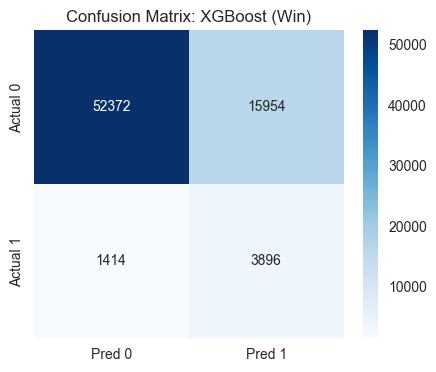

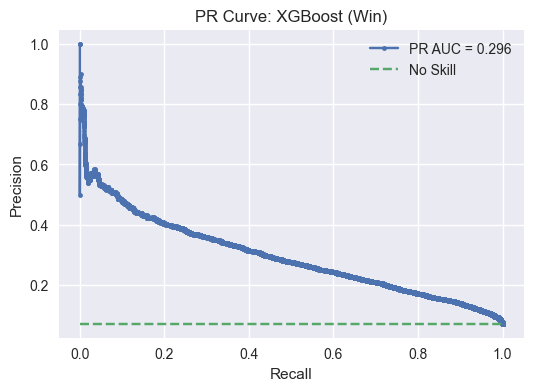

💾 Model tersimpan: trained_models/model_XGBoost_Win.pkl

==================== Training LightGBM (Win) ====================
ROC AUC   : 0.8313
F1 Score  : 0.2910
Recall    : 0.7798
Precision : 0.1789


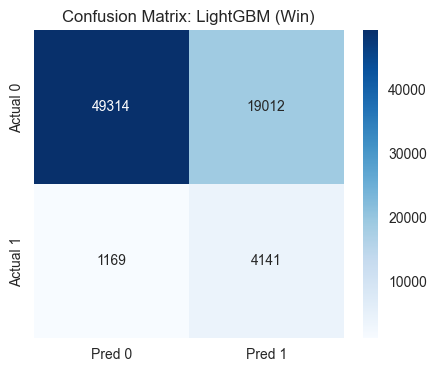

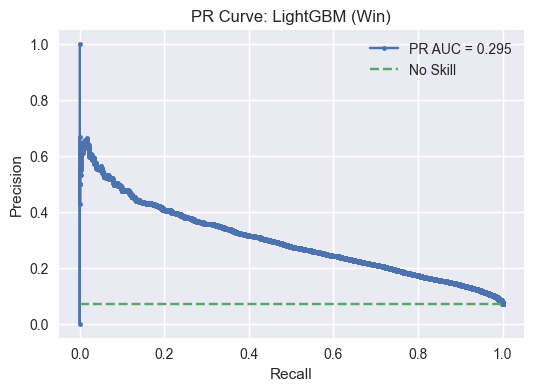

💾 Model tersimpan: trained_models/model_LightGBM_Win.pkl

==================== Training CatBoost (Win) ====================
ROC AUC   : 0.8318
F1 Score  : 0.2912
Recall    : 0.7804
Precision : 0.1790


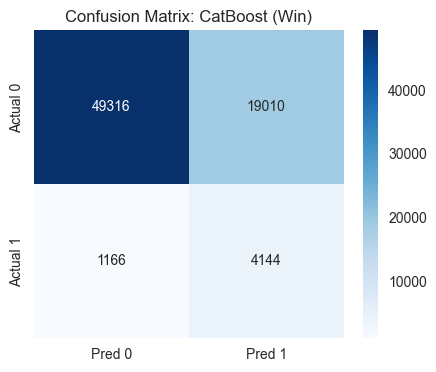

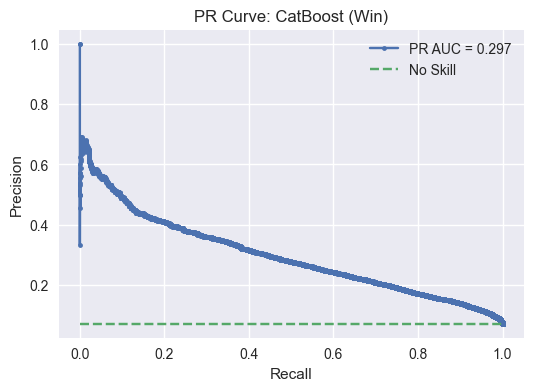

💾 Model tersimpan: trained_models/model_CatBoost_Win.pkl


################# TARGET: Top3 #################

==================== Training LogisticRegression (Top3) ====================
ROC AUC   : 0.8040
F1 Score  : 0.5312
Recall    : 0.7781
Precision : 0.4032


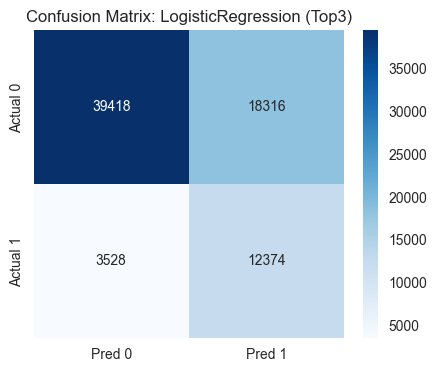

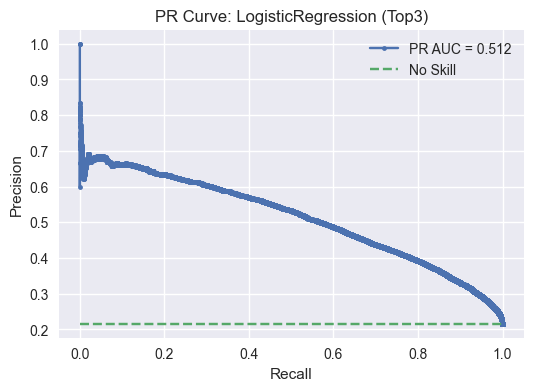

💾 Model tersimpan: trained_models/model_LogisticRegression_Top3.pkl

==================== Training GaussianNB (Top3) ====================
ROC AUC   : 0.7654
F1 Score  : 0.5040
Recall    : 0.6895
Precision : 0.3971


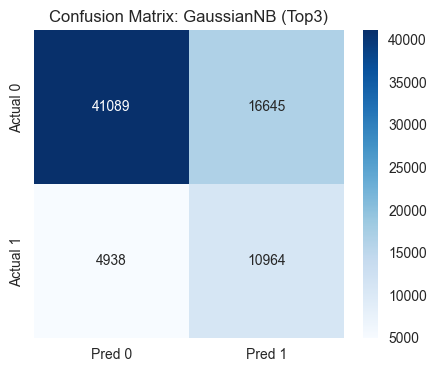

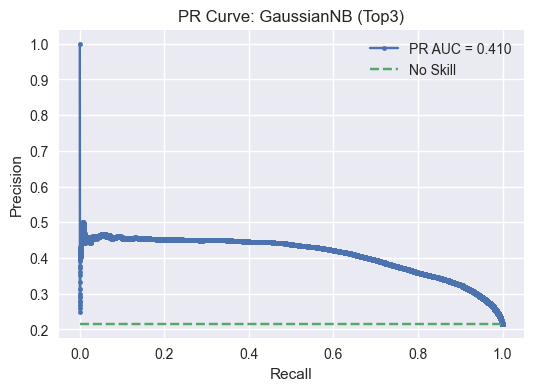

💾 Model tersimpan: trained_models/model_GaussianNB_Top3.pkl

==================== Training XGBoost (Top3) ====================
ROC AUC   : 0.8111
F1 Score  : 0.4687
Recall    : 0.9299
Precision : 0.3133


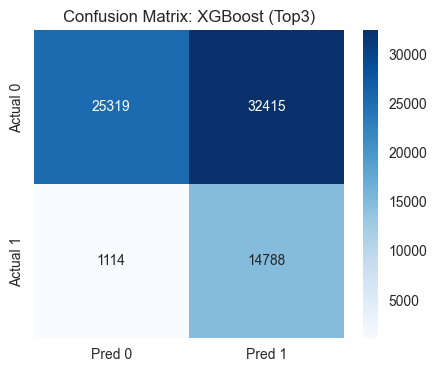

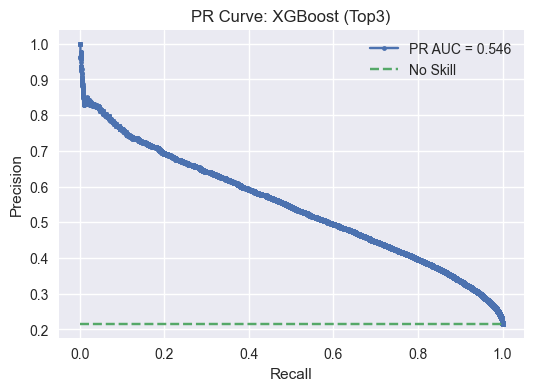

💾 Model tersimpan: trained_models/model_XGBoost_Top3.pkl

==================== Training LightGBM (Top3) ====================
ROC AUC   : 0.8114
F1 Score  : 0.5397
Recall    : 0.7514
Precision : 0.4211


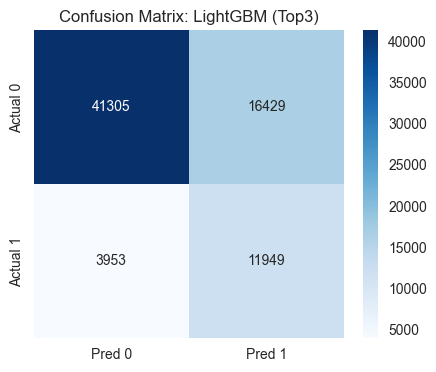

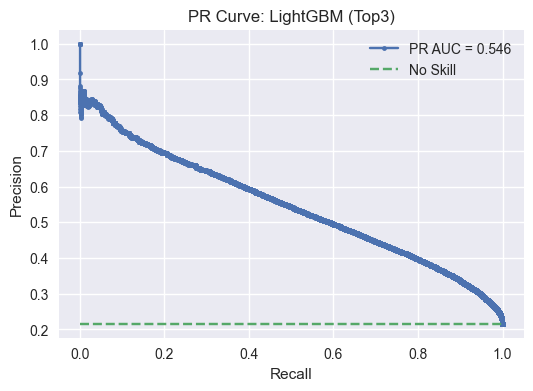

💾 Model tersimpan: trained_models/model_LightGBM_Top3.pkl

==================== Training CatBoost (Top3) ====================
ROC AUC   : 0.8114
F1 Score  : 0.5393
Recall    : 0.7499
Precision : 0.4211


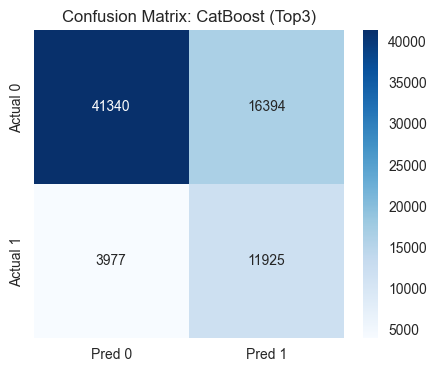

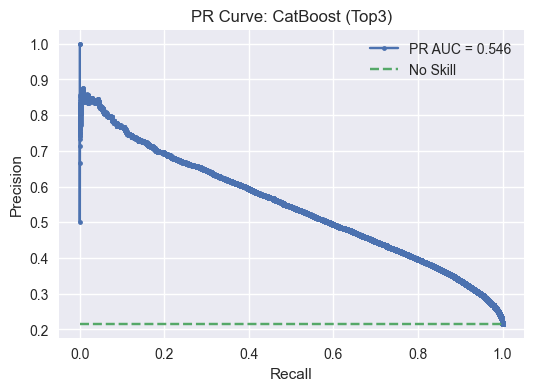

💾 Model tersimpan: trained_models/model_CatBoost_Top3.pkl

=== HASIL AKHIR ===


,Model,AUC,F1,Recall,Precision,PR_AUC
0,LogisticRegression (Win),0.822894,0.275293,0.810923,0.165788,0.255523
1,GaussianNB (Win),0.781167,0.276052,0.577213,0.181404,0.176753
2,XGBoost (Win),0.831303,0.309698,0.733710,0.196272,0.295561
3,LightGBM (Win),0.831349,0.290974,0.779849,0.178854,0.295396
4,CatBoost (Win),0.831801,0.291175,0.780414,0.178976,0.297404
5,LogisticRegression (Top3),0.803959,0.531164,0.778141,0.403193,0.511702
6,GaussianNB (Top3),0.765431,0.503965,0.689473,0.397117,0.409926
7,XGBoost (Top3),0.811112,0.468679,0.929946,0.313285,0.546365
8,LightGBM (Top3),0.811367,0.539702,0.751415,0.421066,0.546076
9,CatBoost (Top3),0.811426,0.539337,0.749906,0.421095,0.546462


In [7]:
import joblib
import os

# --- TAHAP 3: EKSEKUSI MODEL & SAVE ---

# 1. Buat folder untuk menyimpan model (jika belum ada)
save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Folder '{save_dir}' berhasil dibuat.")

# Inisialisasi Model (Sama seperti sebelumnya)
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'GaussianNB': GaussianNB(),
    'XGBoost': XGBClassifier(n_estimators=500, learning_rate=0.05, scale_pos_weight=10, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=500, learning_rate=0.05, auto_class_weights='Balanced', random_state=42, verbose=0)
}

results_log = []

for target_name, target_data in targets.items():
    print(f"\n\n################# TARGET: {target_name} #################")
    
    y_train_cur = target_data['train']
    y_val_cur = target_data['val']
    y_test_cur = target_data['test']
    
    for name, model in models.items():
        # Pilih data yang sesuai
        if name in ['LogisticRegression', 'GaussianNB']:
            X_tr_use = X_train_scaled
            X_v_use = X_val_scaled
            X_te_use = X_test_scaled
            is_tree = False
        else:
            X_tr_use = X_train
            X_v_use = X_val
            X_te_use = X_test
            is_tree = True
            
        try:
            # Training Model
            res = run_model(model, f"{name} ({target_name})", 
                            X_tr_use, y_train_cur, 
                            X_v_use, y_val_cur, 
                            X_te_use, y_test_cur, 
                            is_tree=is_tree)
            results_log.append(res)
            
            # --- BAGIAN BARU: SAVE MODEL ---
            # Nama file contoh: 'trained_models/model_XGBoost_Win.pkl'
            filename = f"{save_dir}/model_{name}_{target_name}.pkl"
            joblib.dump(model, filename)
            print(f"💾 Model tersimpan: {filename}")
            
        except Exception as e:
            print(f"ERROR pada model {name}: {str(e)}")

# Tampilkan Ringkasan Hasil
df_results = pd.DataFrame(results_log)
print("\n=== HASIL AKHIR ===")
display(df_results)